# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque, namedtuple
from tensorboardX import SummaryWriter
from ddpg_agent import DDPG
import torch.nn.functional as F
import matplotlib.pyplot as plt

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
# for i in range(1, 6):                                      # play game for 5 episodes
#     env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#     states = env_info.vector_observations                  # get the current state (for each agent)
#     scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#     while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#         print(actions.shape)
#         actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#         print('actions', actions)
#         env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#         next_states = env_info.vector_observations         # get next state (for each agent)
#         print('next_states',next_states.shape)
        
#         rewards = env_info.rewards                         # get reward (for each agent)
#         dones = env_info.local_done                        # see if episode finished
#         print('rewards',rewards.shape)
#         print('dones',dones.shape)
#         scores += env_info.rewards                         # update the score (for each agent)
#         states = next_states                               # roll over states to next time step
#         if np.any(dones):                                  # exit loop if episode finished
#             break
#         break
#     print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [7]:
def run_maddpg(episodes, agent,experiment_name):

    max_steps = 1000
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    BUFFER_SIZE = int(1e5) # int(1e6) # int(1e5)  # replay buffer size  ?
    BATCH_SIZE = 64 # 128 # 64 # 256        # minibatch size for training
    GAMMA = 0.99            # discount factor
    TAU = 1e-3              # for soft update of target parameters
    LR_ACTOR = 5e-4 # 1e-3 # 1e-4 # 5e-4 # 1e-4 # 0.001 # 1e-4         # learning rate of the actor 
    LR_CRITIC = 6e-4 # 3e-3 # 3e-4  # 6e-4 # 3e-4  # 3e-3 # 0.001 # 3e-4        # learning rate of the critic 0.001
    WEIGHT_DECAY = 0.0001   # L2 weight decay
    # Number of neurons in the layers of the Actor & Critic Networks

    tb_writer = SummaryWriter('{}/{}'.format('logs',experiment_name))

    scores_window = deque(maxlen=100)
    steps_window = deque(maxlen=100)
    scores = []
    max_score = 0.5
    best_score = None
    episode_count = 1
    for episode in range(1, episodes+1):
        episode_count = episode
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                 # get the current state (for each agent)
        agent.reset()
        episode_score = 0
        step_count = 0
        dones = np.zeros((num_agents), dtype=bool)
        while not np.any(dones) and step_count< max_steps :
            actions=[]
            for i in range(num_agents):
                action = agent.act(states[i])
                actions.append(action)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards =  env_info.rewards                        # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            for i in range(num_agents):
                agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i])
            states = next_states                               # roll over states to next time step
            episode_score += np.max(env_info.rewards)
            step_count += 1
            
        scores_window.append(episode_score)
        scores.append(episode_score)
        
        avg_score = np.mean(scores_window)
        print('\rEpisode:{}\taverage_score:{:.2f}\tEpisode Score: {:.2f}'.format(episode, avg_score, episode_score),end="")
        if episode % 100 == 0 :
            print('\rEpisode:{}\tAverage Score:{:.2f}'.format(episode, avg_score))  
        if  avg_score >= max_score:
            save_model = False
            if best_score is None:
                best_score = avg_score
                save_model = True
            else:
                if avg_score > best_score:
                    best_score = avg_score
                    save_model = True
                else:
                    break
            if save_model is True:
                torch.save(agent.actor.state_dict(), 'actor_checkpoint.pth')
                torch.save(agent.critic.state_dict(), 'critic_checkpoint.pth')
    return scores, best_score, episode_count
           
agent = DDPG(state_size=state_size, action_size=action_size, seed=42, device = device,\
                buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, actor_learrning_rate=LR_ACTOR,\
                critic_learning_rate=LR_CRITIC,gamma=GAMMA, tau=TAU, optimizer_weight_decay=WEIGHT_DECAY)
scores, best_score, episode_count = run_maddpg(10000, agent, experiment_name="test" )

cpu
Episode:100	Average Score:0.00	Episode Score: 0.00
Episode:200	Average Score:0.00	Episode Score: 0.00
Episode:300	Average Score:0.00	Episode Score: 0.00
Episode:400	Average Score:0.00	Episode Score: 0.00
Episode:500	Average Score:0.00	Episode Score: 0.00
Episode:600	Average Score:0.01	Episode Score: 0.00
Episode:700	Average Score:0.08	Episode Score: 0.00
Episode:800	Average Score:0.08	Episode Score: 0.00
Episode:900	Average Score:0.07	Episode Score: 0.10
Episode:1000	Average Score:0.06	Episode Score: 0.00
Episode:1100	Average Score:0.07	Episode Score: 0.00
Episode:1200	Average Score:0.08	Episode Score: 0.10
Episode:1300	Average Score:0.08	Episode Score: 0.10
Episode:1400	Average Score:0.08	Episode Score: 0.00
Episode:1500	Average Score:0.05	Episode Score: 0.00
Episode:1600	Average Score:0.04	Episode Score: 0.00
Episode:1700	Average Score:0.08	Episode Score: 0.10
Episode:1800	Average Score:0.09	Episode Score: 0.00
Episode:1900	Average Score:0.11	Episode Score: 0.20
Episode:2000	Aver

### Experiment 1

Actor Network: Actor(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
Critic Network: Critic(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=66, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
Best score: 0.7580000112950802


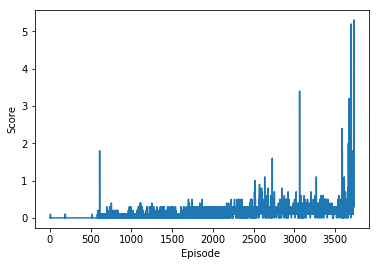

In [19]:
'''
Actor Network: Actor(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
Critic Network: Critic(
  (fc1): Linear(in_features=24, out_features=64, bias=True)
  (fc2): Linear(in_features=66, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)
'''

print('Actor Network:',agent.actor)
print('Critic Network:',agent.critic)
print('Best score:', best_score)
print('Ended in {} of episodes.'.format(3733))
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)),scores)
plt.xlabel('Episode ')
plt.ylabel('Score')
plt.show()


cpu


In [ ]:
env_info.local_done 